# Offline Replayer Evaluation III - Amazon electronics dataset
> Running bandit models on amazon electronics ratings dataset for offline evaluation

- toc: true
- badges: true
- comments: true
- categories: [amazon, bandit]
- image: 

## Environment setup

### Libraries

In [24]:
import os
import sys
import time
import json
import datetime
import logging
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Data

In [2]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d saurav9786/amazon-product-reviews

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=f2ea35314de4384f41ca680222631178d493b16823a0b1e9f5c0227a65caafbf
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100% 109M/109M [00:01<00:00, 62.7MB/s] 
100% 109M/109M [00:01<00:00, 78.4MB/s]


In [3]:
!unzip amazon-product-reviews.zip

Archive:  amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


### Utils

In [5]:
# getting the current system time
current_time = datetime.datetime.now().strftime("%Y-%m-%d__%H.%M")

# run folder which will be unique always
run_folder = str(datetime.datetime.now())

# temprary folder location to export the results
temp_folder = "./output/"

# target folder to export all the result
target_dir = temp_folder + '/' + run_folder

# checking if the temp folder exists. Create one if not
check_folder = os.path.isdir(target_dir)
if not check_folder:
    os.makedirs(target_dir)
    print("created folder : ", target_dir)

# latency dictionary to hold execution time
latency = dict()

# removing any existing log files if present
if os.path.exists(target_dir + '/main.log'):
    os.remove(target_dir+ '/main.log')

created folder :  ./output//2021-06-16 21:35:53.937354


In [6]:
def get_loggers(temp_path):
  # name the logger as HPC-AI skunkworks
  logger = logging.getLogger("Multi-Arm-Bandit")
  logger.setLevel(logging.INFO)
  # file where the custom logs needs to be handled
  f_hand = logging.FileHandler(temp_path + '/.log')
  f_hand.setLevel(logging.INFO)  # level to set for logging the errors
  f_format = logging.Formatter('%(asctime)s : %(levelname)s : %(message)s',
                                datefmt='%d-%b-%y %H:%M:%S')
  # format in which the logs needs to be written
  f_hand.setFormatter(f_format)  # setting the format of the logs
  # setting the logging handler with the above formatter specification
  logger.addHandler(f_hand)

  stdout_handler = logging.StreamHandler()
  stdout_handler.setFormatter(f_format)
  logger.addHandler(stdout_handler)

  return logger

In [7]:
# get custom logger
logger = get_loggers(target_dir)

In [9]:
def export_to_json(dictionary, file_name):
  try:
    start = time.time()
    json_data = json.dumps(dictionary, indent=4)
    file = open(file_name, 'w')
    print(json_data, file=file)
    # updating into json
    file.close()
    stop = time.time()
    latency['export_to_json_'] = stop - start
    logger.info('Data exported to JSON successfully!')
  except Exception as e:
    logger.exception(e)
    sys.exit(1)

## Defining agents

In [10]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

This script is used for simulating AB testing simulator

'''

import numpy as np
from tqdm import tqdm


class ABTestReplayer():
    '''
    A class to provide functionality for simulating the method on an A/B test.
    '''
    
    def __init__(self, n_visits, n_test_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations

        
        # TODO: validate that n_test_visits <= n_visits
    
        self.n_test_visits = n_test_visits

        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None
        
    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
        self.is_testing = True
        self.best_item_idx = None
    
    def select_item(self):
        if self.is_testing:
            return np.random.randint(self.n_items)
        else:
            return self.best_item_idx
            
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]

        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])
        
        if (visit == self.n_test_visits - 1): # this was the last visit during the testing phase
            
            self.is_testing = False
            self.best_item_idx = np.argmax(self.n_item_rewards)

    def simulator(self):
    
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [11]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''

import numpy as np
from tqdm import tqdm

class EpsilonGreedyReplayer():
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon

        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = np.random.randint(self.n_items)
            
        else: # exploit
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id
    
    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)

    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

    
    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [12]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''

import numpy as np
from tqdm import tqdm

class ThompsonSamplingReplayer():
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm

    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations
    


        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None

    def reset(self):
        self.alphas = np.ones(self.n_items)
        self.betas = np.ones(self.n_items)

    def select_item(self):
    
        samples = [np.random.beta(a,b) for a,b in zip(self.alphas, self.betas)]
        
        return np.argmax(samples)

    def record_result(self, visit, item_idx, reward):
        
        # update value estimate
        if reward == 1:
            self.alphas[item_idx] += 1
        else:
            self.betas[item_idx] += 1



    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [13]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''
import numpy as np
from tqdm import tqdm


class ReplaySimulator(object):
    '''
    A class to provide base functionality for simulating the replayer method for online algorithms.
    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):

        np.random.seed(random_seed)
    
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of visits to replay/simulate
        self.n_visits = n_visits
        
        # number of runs to average over
        self.n_iterations = n_iterations
    
        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        

    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
    
    def replay(self):
        
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                ## record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results
        
    def select_item(self):
        return np.random.randint(self.n_items)
        
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

In [14]:
'''

Author - Abhishek Maheshwarappa and Jiaxin Tong

'''

import numpy as np
from tqdm import tqdm

class UCBSamplingReplayer():
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm

    '''

    def __init__(self,ucb_c, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.ucb_c = ucb_c

        # number of runs to average over
        self.n_iterations = n_iterations
    


        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None

    def reset(self):
        self.Q = np.zeros(self.n_items) # q-value of actions
        self.N = np.zeros(self.n_items) + 0.0001 # action count
        self.timestep = 1


    def select_item(self):

        ln_timestep = np.log(np.full(self.n_items, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)

        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        
        return action

    def record_result(self, visit, item_idx, reward):
        
        # update value estimate
        self.N[item_idx] += 1 # increment action count
        self.Q[item_idx] += 1/self.N[item_idx] * (reward - self.Q[item_idx]) # inc. update rule


    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

## Running simulation

In [16]:
logger.info("Multi-Armed-Bandits-for-Recommendations-and-A-B-testing !!!")
logger.info("Current time: " + str(current_time))

logger.info("Reading the data..!!")

start = time.time()
header_list = ["User_ID", "Product_ID", "Rating", "Time_Stamp"]
rating_df = pd.read_csv('ratings_Electronics (1).csv', names=header_list)
latency["Data_reading -"] = time.time() - start
logger.info("Read the data Successfully ..!!!")

reward_threshold = 4
rating_df['reward'] = rating_df.eval('Rating > @reward_threshold').astype(int)

16-Jun-21 22:00:41 : INFO : Multi-Armed-Bandits-for-Recommendations-and-A-B-testing !!!
16-Jun-21 22:00:41 : INFO : Current time: 2021-06-16__21.35
16-Jun-21 22:00:41 : INFO : Reading the data..!!
16-Jun-21 22:00:47 : INFO : Read the data Successfully ..!!!


In [19]:
n_visits = 500
n_iterations = 1
n_test_visits = 100

reward_history = rating_df[:1000]
item_col_name = 'Product_ID'
visitor_col_name = 'User_ID'
reward_col_name = 'reward'

In [20]:
#################### A/B testing ###############

logger.info("A/B Test Simulations...starts...!!!")

start = time.time()
ab_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                            item_col_name, visitor_col_name, reward_col_name,
                            n_iterations=n_iterations).simulator()

ab_results_df = pd.DataFrame(ab_results)
latency["A/B testing -"] = time.time() - start

logger.info("A/B testing completed Successfully..!!")

ab_results_df.to_csv(target_dir + '/ab_results_df.csv')

logger.info("Saving the A/B test results saved Successfully..!!")

16-Jun-21 22:01:52 : INFO : A/B Test Simulations...starts...!!!

100%|██████████| 1/1 [03:07<00:00, 187.56s/it]
16-Jun-21 22:04:59 : INFO : A/B testing completed Successfully..!!
16-Jun-21 22:04:59 : INFO : Saving the A/B test results saved Successfully..!!


In [21]:
################# Epsilon - Greedy Simulations ##############

logger.info("Epsilon - Greedy Simulations...starts...!!!")

start = time.time()
epsilon = 0.05
epsilon_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                        item_col_name, visitor_col_name, reward_col_name,
                                        n_iterations=n_iterations).simulator()

epsilon_results_df = pd.DataFrame(epsilon_results)
latency["Epsilon - Greedy Simulations  -"] = time.time() - start
logger.info("Epsilon - Greedy Simulations completed Successfully..!!")

epsilon_results_df.to_csv(target_dir +'/epsilon_results_df.csv')

logger.info("Epsilon - Greedy Simulations results saved Successfully..!!")

16-Jun-21 22:04:59 : INFO : Epsilon - Greedy Simulations...starts...!!!

100%|██████████| 1/1 [10:38<00:00, 638.64s/it]
16-Jun-21 22:15:38 : INFO : Epsilon - Greedy Simulations completed Successfully..!!
16-Jun-21 22:15:38 : INFO : Epsilon - Greedy Simulations results saved Successfully..!!


In [22]:
################### Thompson Sampling Simulations #######################

logger.info("Thompson Sampling Simulations...starts...!!!")

start = time.time()

thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).simulator()

thompson_results_df = pd.DataFrame(thompson_results)
latency["Thompson Sampling Simulations  -"] = time.time() - start
logger.info("Thompson Sampling Simulations completed Successfully..!!")

thompson_results_df.to_csv(target_dir +'/thompson_results_df.csv')

logger.info("Thompson Sampling Simulations results saved Successfully..!!")

16-Jun-21 22:15:38 : INFO : Thompson Sampling Simulations...starts...!!!

100%|██████████| 1/1 [11:51<00:00, 711.80s/it]
16-Jun-21 22:27:30 : INFO : Thompson Sampling Simulations completed Successfully..!!
16-Jun-21 22:27:30 : INFO : Thompson Sampling Simulations results saved Successfully..!!


In [23]:
####################  Upper Confidence Bounds #########################

logger.info("Upper Confidence Bounds Simulations...starts...!!!")

start = time.time()

ucb = 2

ucb_results = UCBSamplingReplayer(ucb, n_visits, reward_history,
                                  item_col_name, visitor_col_name, reward_col_name,
                                  n_iterations=n_iterations).simulator()

ucb_results_df = pd.DataFrame(ucb_results)
latency["Upper Confidence Bounds Simulations  -"] = time.time() - start

logger.info("Upper Confidence Bounds Simulations completed Successfully..!!")

ucb_results_df.to_csv(target_dir +'/ucb_results_df.csv')

logger.info("Upper Confidence Bounds Simulations results saved Successfully..!!")

logger.info('Exporting the latency')
file_name = target_dir +'/latency_stats.json'
export_to_json(latency, file_name)
logger.info("Program completed normally")
logger.handlers.clear()

16-Jun-21 22:27:30 : INFO : Upper Confidence Bounds Simulations...starts...!!!

100%|██████████| 1/1 [14:35<00:00, 875.29s/it]
16-Jun-21 22:42:05 : INFO : Upper Confidence Bounds Simulations completed Successfully..!!
16-Jun-21 22:42:05 : INFO : Upper Confidence Bounds Simulations results saved Successfully..!!
16-Jun-21 22:42:05 : INFO : Exporting the latency
16-Jun-21 22:42:05 : INFO : Data exported to JSON successfully!
16-Jun-21 22:42:05 : INFO : Program completed normally


## Result analysis

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,0132793040,AKM1MP6P0OYPR,1,1,1.000000
1,0,1,0321732944,A2CX7LUOHB2NDG,1,2,1.000000
2,0,2,0439886341,A2NWSAGRHCP8N5,0,2,0.666667
3,0,3,0511189877,A2TY0BTJOTENPG,1,3,0.750000
4,0,4,0528881469,A3T6ZQONABIJSG,0,3,0.600000
...,...,...,...,...,...,...,...
495,0,495,0594511488,A29FNXHYVA2W4G,1,320,0.645161
496,0,496,0594514789,A1APJUGO70YI8,1,321,0.645875
497,0,497,0594549558,A3JQESKSRFB6MV,1,322,0.646586
498,0,498,0777700018,A2E14J26DQZOAA,1,323,0.647295


In [28]:

'''
The Csv files present in current 
output run directory are Read 
for all the algos

'''

ucb_results_df = pd.read_csv(os.path.join(target_dir,'ucb_results_df.csv')).drop('Unnamed: 0', axis=1)
thompson_results_df = pd.read_csv(os.path.join(target_dir,'thompson_results_df.csv')).drop('Unnamed: 0', axis=1)
epsilon_results_df = pd.read_csv(os.path.join(target_dir,'epsilon_results_df.csv')).drop('Unnamed: 0', axis=1)
ab_results_df = pd.read_csv(os.path.join(target_dir,'ab_results_df.csv')).drop('Unnamed: 0', axis=1)

In [29]:
'''
Grouping the each data frame with visit with mean
'''

ucb_avg_results_df = ucb_results_df.groupby('visit', as_index=False).mean()

thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()

epsilon_avg_results_df = epsilon_results_df.groupby('visit', as_index=False).mean()

ab_avg_results_df = ab_results_df.groupby('visit', as_index=False).mean()

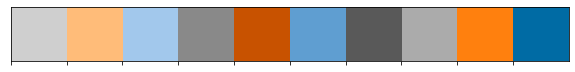

In [30]:
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

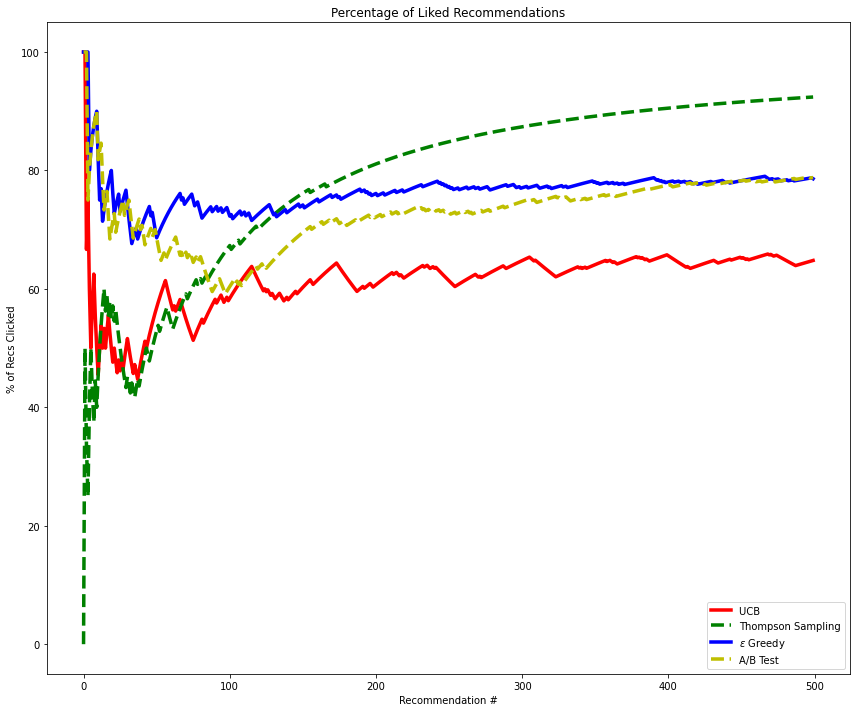

In [31]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_df, style) in [(ucb_avg_results_df, 'r-'),
                                (thompson_avg_results_df, 'g--'),
                                (epsilon_avg_results_df, 'b-'),
                                (ab_avg_results_df, 'y--')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)


ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Clicked')

#ax.set_xticks(range(0,22000,5000))
#ax.set_ylim(0.2, 0.6)
#ax.set_yticks(np.arange(0.2, 0.7, 0.1))

#rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['UCB ',
           'Thompson Sampling',
           '$\epsilon$ Greedy',
           'A/B Test'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

From the above it is clear that Thompson smapling of multi arm bandit outperforms A/B testing. In the lower samples the Epsilon Greedy better than all other algorithim, but as in when the number smaples increase the thompsonsampling starts performing beter and better.

## License

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.